In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [3]:
path=os.getcwd()
path

'C:\\Users\\user\\Documents\\multivariate-time-series-prediction'

In [5]:
file=pd.read_csv(path+'/datasets/exchange_rate.csv')


In [6]:

del file['China']
data=(file-file[:-2000].min())/(file[:-2000].max()-file[:-2000].min())
scale=[file[:-2000].max().tolist(),file[:-2000].min().tolist()]
data1=data.values
scale

[[1.023657,
  2.109,
  1.091524,
  1.1097549999999998,
  0.012671,
  0.81635,
  0.7898890000000001],
 [0.483297, 1.372313, 0.618582, 0.548617, 0.006254, 0.393153, 0.523834]]

In [7]:
data.shape

(7587, 7)

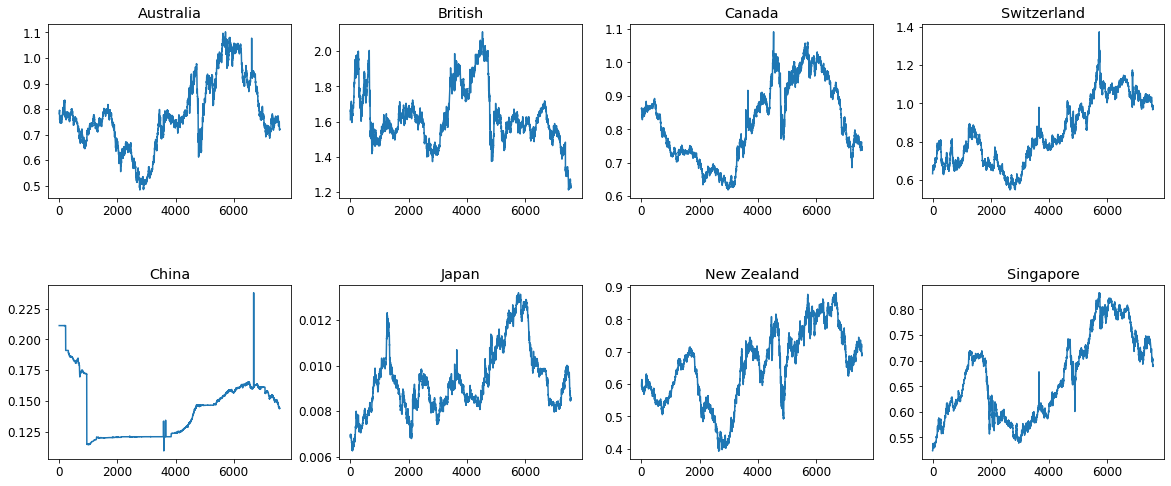

In [17]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(20,8))
for i in range(len(file.columns)):
    plt.subplot(241+i)
    plt.plot(file[file.columns[i]])
    plt.title(file.columns[i])
plt.subplots_adjust(hspace = 0.5)

# generate inputs and outputs

In [8]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors

    

def make_io(data, input_len, output_len, neighbors, split_size, shuffle=True):
    #neighbors should be a list where neighbors[0] is the target
    
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
    data_len=data.shape[0]
    data_dim=data.shape[1]

    
    
    for j in range(data_len-input_len-output_len):
        one_x=[]
        one_y=[]
        i=neighbors[0]
        s=[scale[0][i],scale[1][i]]
        for k in neighbors:
                one_x.append(data[j:j+input_len,k].reshape(input_len,-1))
                one_y.append(data[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
        one_x=np.concatenate(one_x,axis=1)
        one_y=np.concatenate(one_y,axis=1)
        one_data=[one_x.tolist(),one_y.tolist(),s]
            
        if j<(data_len-split_size):
            dataset1.append(one_data)
        else:
            dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


# training function

In [8]:
def train(inputs, epochs, input_dim, input_len, output_len, split, model, loss_func, folder, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(data.columns[target])
    
    
    dataset1,dataset2=make_io(input_len,output_len,inputs,split)
    dataset3,dataset4=make_io(input_len,output_len,inputs,split,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,data.columns[target], target, 
                     scale, path+ '/results/plots/exchange_rate/'+method+'/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, Y_train_valid, X_test_valid, Y_test_valid
    

In [6]:
input_len=14
output_len=7
split=2000
input_dim=7
inputs=make_neighbor_list(0, input_dim)
dataset1,dataset2=make_io(input_len,output_len,inputs,split,False)
X_train=torch.FloatTensor(dataset1[0])
Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)


In [13]:
X_train[0:3,-1,:1]

tensor([[0.5400],
        [0.5161],
        [0.5089]])

In [14]:
data1[0:17,0]

array([0.55241506, 0.56148309, 0.56018765, 0.55815197, 0.56129802,
       0.56499926, 0.56944074, 0.57480754, 0.56647975, 0.57073618,
       0.57517766, 0.57406729, 0.57758346, 0.54001592, 0.51614294,
       0.50892553, 0.51299689])

# Set gpu and loss functions

In [24]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


In [38]:
importlib.reload(util)

<module 'src.util' from '/media/data/home/darcy/master_summary/src/util.py'>

# train models

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
    (W): Linear(in_features=20, out_features=20, bias=False)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 40, batch_first=True)
    (fc1): Linear(in_features=40, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
New Zealand
number of parmeters: 6373
epoch:0
training mae loss:0.4622623026371002
testing mae loss:0.8137977123260498
testing mape:0.4406877
epoch:100
training mae loss:0.04809729568660259
testing mae loss:0.0861607864499

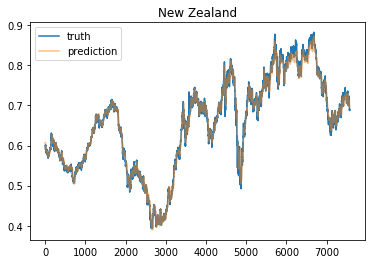

mae:  0.027269572
mape:  0.0147983115
smape:  0.01486405


<Figure size 432x288 with 0 Axes>

In [39]:
import src.model

method='general'

targets=[5]
input_dim=7
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=14
output_length=7

split=2000
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method=method)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    #torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [36]:
torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')

basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Australia
number of parmeters: 10273
epoch:0
training mae loss:0.46754151582717896
testing mae loss:0.7460172176361084
testing mape:0.4391749
epoch:100
training mae loss:0.06177256070077419
testing mae loss:0.10336139798164368
testing mape:0.06462788
epoch:200
training mae loss:0.0497236642986536
testing mae loss:0.09420114010572433
testing mape:0.059272323
epoch:300
training mae loss:0.043440211564302444
testing mae loss:0.08216513693332672
testing mape:0.05233633
epoch:400
training mae loss:0.04070877656340599
testing mae loss:0.07705775648355484
testing mape:0.048815437
epoch:500
training mae loss:0.035581814125180244
testing mae loss:0.05234673246741295
testing mape:0.029972956
epoch:600
training mae loss:0.0230990843847394
testing mae loss:0.0536225

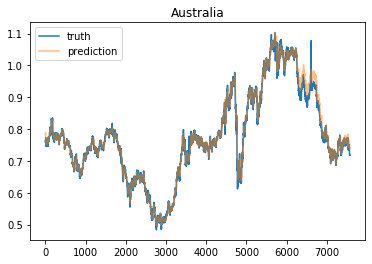

mae:  0.032923236
mape:  0.019832147
smape:  0.01956155
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
British
number of parmeters: 10273
epoch:0
training mae loss:0.300661563873291
testing mae loss:0.17220264673233032
testing mape:0.081759155
epoch:100
training mae loss:0.05368201062083244
testing mae loss:0.053008921444416046
testing mape:0.027015463
epoch:200
training mae loss:0.04609109088778496
testing mae loss:0.0517842173576355
testing mape:0.026370792
epoch:300
training mae loss:0.04159998707473278
testing mae loss:0.049426961690187454
testing mape:0.025216399
epoch:400
training mae loss:0.03947100602090359
testing mae loss:0.04372156411409378
testing mape:0.022451796
epoch:500
training mae loss:0.033578744158148766
testing mae loss:0.06442325562238693
testing mape:0.032451667
epoch:600
train

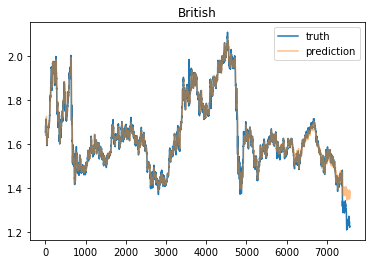

mae:  0.02784527
mape:  0.014594975
smape:  0.014250643
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Canada
number of parmeters: 10273
epoch:0
training mae loss:0.5468558669090271
testing mae loss:0.7408811450004578
testing mape:0.38298458
epoch:100
training mae loss:0.0558274257928133
testing mae loss:0.12574926018714905
testing mape:0.07061303
epoch:200
training mae loss:0.047533193603158
testing mae loss:0.1317862868309021
testing mape:0.07526383
epoch:300
training mae loss:0.04284314438700676
testing mae loss:0.13564345240592957
testing mape:0.0773621
epoch:400
training mae loss:0.03877653367817402
testing mae loss:0.13222189247608185
testing mape:0.07506908
epoch:500
training mae loss:0.03461619094014168
testing mae loss:0.06668680906295776
testing mape:0.037088275
epoch:600
training mae loss:

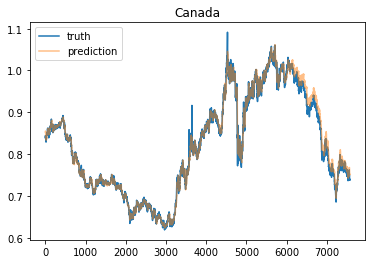

mae:  0.029419074
mape:  0.015840568
smape:  0.015678214
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Switzerland
number of parmeters: 10273
epoch:0
training mae loss:0.3279307335615158
testing mae loss:0.8581694960594177
testing mape:0.44826213
epoch:100
training mae loss:0.05514541082084179
testing mae loss:0.15923486649990082
testing mape:0.08288008
epoch:200
training mae loss:0.046750908717513084
testing mae loss:0.14347417652606964
testing mape:0.07457072
epoch:300
training mae loss:0.04075292497873306
testing mae loss:0.12759456038475037
testing mape:0.066190675
epoch:400
training mae loss:0.03676752373576164
testing mae loss:0.1411699801683426
testing mape:0.07354168
epoch:500
training mae loss:0.030350816436111927
testing mae loss:0.1638791859149933
testing mape:0.085704155
epoch:600
traini

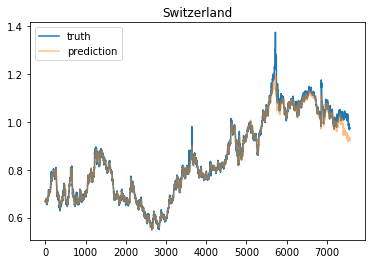

mae:  0.039793327
mape:  0.020676663
smape:  0.021142315
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Japan
number of parmeters: 10273
epoch:0
training mae loss:0.2564360797405243
testing mae loss:0.408669114112854
testing mape:0.23942795
epoch:100
training mae loss:0.06192577816545963
testing mae loss:0.18461675941944122
testing mape:0.12540647
epoch:200
training mae loss:0.04810008592903614
testing mae loss:0.13425327837467194
testing mape:0.08968897
epoch:300
training mae loss:0.04236984811723232
testing mae loss:0.10826089978218079
testing mape:0.071638845
epoch:400
training mae loss:0.03899669274687767
testing mae loss:0.0956256240606308
testing mape:0.063017815
epoch:500
training mae loss:0.03175423853099346
testing mae loss:0.1338033229112625
testing mape:0.091644414
epoch:600
training mae l

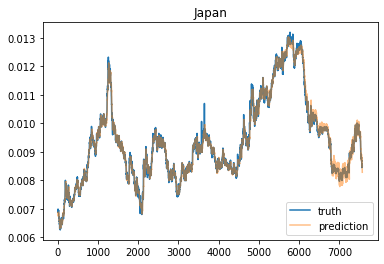

mae:  0.019441515
mape:  0.012512245
smape:  0.012479272
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
New Zealand
number of parmeters: 10273
epoch:0
training mae loss:0.6607081294059753
testing mae loss:1.0370807647705078
testing mape:0.5634075
epoch:100
training mae loss:0.06541712395846844
testing mae loss:0.07871916145086288
testing mape:0.041884065
epoch:200
training mae loss:0.05853525176644325
testing mae loss:0.08450829237699509
testing mape:0.044824287
epoch:300
training mae loss:0.054513199254870415
testing mae loss:0.07983998209238052
testing mape:0.042396426
epoch:400
training mae loss:0.05161008611321449
testing mae loss:0.07598254829645157
testing mape:0.040394478
epoch:500
training mae loss:0.04634980857372284
testing mae loss:0.12588916718959808
testing mape:0.06658826
epoch:600
trai

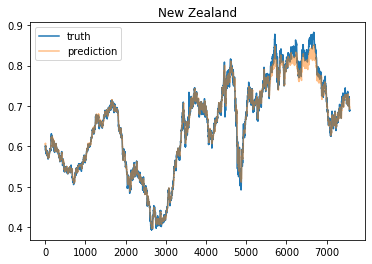

mae:  0.035001982
mape:  0.01852337
smape:  0.018744115
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Singapore
number of parmeters: 10273
epoch:0
training mae loss:0.23719200491905212
testing mae loss:0.71748948097229
testing mape:0.24559572
epoch:100
training mae loss:0.03817369416356087
testing mae loss:0.15356169641017914
testing mape:0.052591465
epoch:200
training mae loss:0.03398984298110008
testing mae loss:0.13845345377922058
testing mape:0.047341857
epoch:300
training mae loss:0.031450661830604076
testing mae loss:0.12544217705726624
testing mape:0.04286961
epoch:400
training mae loss:0.02973044477403164
testing mae loss:0.11946916580200195
testing mape:0.040803302
epoch:500
training mae loss:0.02417647000402212
testing mae loss:0.052501555532217026
testing mape:0.017836375
epoch:600
traini

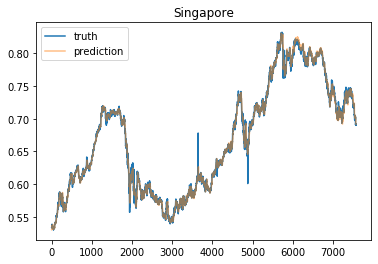

mae:  0.016673923
mape:  0.0057750815
smape:  0.005768377


<Figure size 432x288 with 0 Axes>

In [8]:
import src.lstm_lstm

method=""

targets=[0,1,2,3,4,5,6]
input_dim=7

hidden_size=32
fc_size=16
input_length=14
output_length=7

split=2000
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #basic_S2S(hidden_size,fc_size,input_length,input_dim,output_length)
    model=src.lstm_lstm.basic_S2S(hidden_size, fc_size, input_length, input_dim, output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/lstm/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Australia
number of parmeters: 7669
epoch:0
training mae loss:0.5396947860717773
testing mae loss:0.8297432661056519
testing mape:0.49064028
epoch:100
training mae loss:0.05111096613109112
testing mae loss:0.07947663217782974
testing mape:0.043702926
epoch:200
training mae loss:0.045489631593227386
testing mae loss:0.06886284798383713
testing mape:0.037942026
epoch:300
training mae loss:0.0414902176707983
testing mae loss:0.06404174864292145
testing mape:0.03530009
epoch:400
training mae loss:0.03840774483978748
testing mae loss:0.06141190230846405
testing mape:0.033828165
epoch:500
training mae loss:0.03472416661679745
testing mae loss:0.05957023426890373
testing 

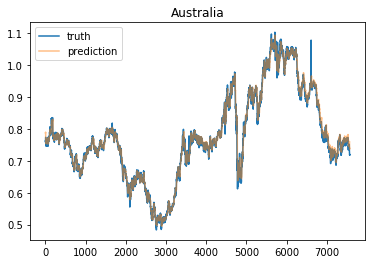

mae:  0.020291863
mape:  0.012572305
smape:  0.012491991
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
British
number of parmeters: 7669
epoch:0
training mae loss:0.25677822530269623
testing mae loss:0.13443705439567566
testing mape:0.06506642
epoch:100
training mae loss:0.05071713216602802
testing mae loss:0.0948067381978035
testing mape:0.046939027
epoch:200
training mae loss:0.044778479263186455
testing mae loss:0.09092313051223755
testing mape:0.045048505
epoch:300
training mae loss:0.04128764383494854
testing mae loss:0.08167032897472382
testing mape:0.040683832
epoch:400
training mae loss:0.03879750519990921
testing mae loss:0.07505187392234802
testing mape:0.03760481
epoch:500
training mae loss:0.034790

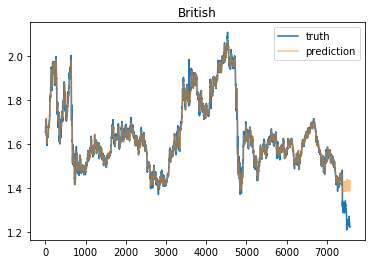

mae:  0.030565495
mape:  0.016430482
smape:  0.015801225
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Canada
number of parmeters: 7669
epoch:0
training mae loss:0.2639120817184448
testing mae loss:0.43542638421058655
testing mape:0.21921282
epoch:100
training mae loss:0.05935586988925934
testing mae loss:0.03007429465651512
testing mape:0.015698642
epoch:200
training mae loss:0.046223752200603485
testing mae loss:0.030960332602262497
testing mape:0.01622105
epoch:300
training mae loss:0.04032489284873009
testing mae loss:0.02893054112792015
testing mape:0.015180683
epoch:400
training mae loss:0.036699941381812096
testing mae loss:0.02745893970131874
testing mape:0.014439747
epoch:500
training mae loss:0.02862

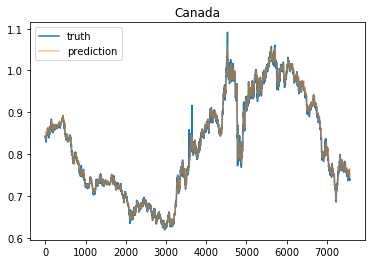

mae:  0.012761751
mape:  0.0068592234
smape:  0.00683879
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Switzerland
number of parmeters: 7669
epoch:0
training mae loss:0.4128158390522003
testing mae loss:0.9351581931114197
testing mape:0.48869738
epoch:100
training mae loss:0.0627726037055254
testing mae loss:0.2057485580444336
testing mape:0.108448744
epoch:200
training mae loss:0.05684947036206722
testing mae loss:0.18528324365615845
testing mape:0.0977738
epoch:300
training mae loss:0.0524164866656065
testing mae loss:0.17578554153442383
testing mape:0.09275356
epoch:400
training mae loss:0.04866439290344715
testing mae loss:0.1691547930240631
testing mape:0.08921139
epoch:500
training mae loss:0.04056918993

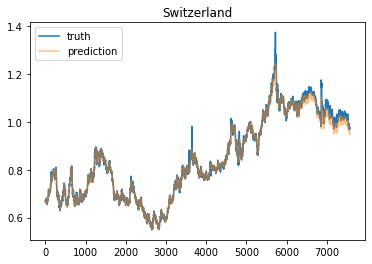

mae:  0.036068615
mape:  0.01877204
smape:  0.019034846
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Japan
number of parmeters: 7669
epoch:0
training mae loss:0.43549150228500366
testing mae loss:0.6061347126960754
testing mape:0.36703956
epoch:100
training mae loss:0.04634135216474533
testing mae loss:0.1550787091255188
testing mape:0.106991865
epoch:200
training mae loss:0.041610345244407654
testing mae loss:0.1381763070821762
testing mape:0.09516715
epoch:300
training mae loss:0.0392120648175478
testing mae loss:0.12748706340789795
testing mape:0.0877511
epoch:400
training mae loss:0.037355704233050346
testing mae loss:0.11928392201662064
testing mape:0.0821116
epoch:500
training mae loss:0.031313108280301

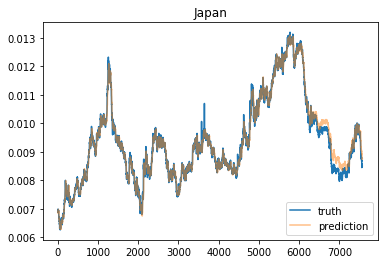

mae:  0.031338748
mape:  0.02155922
smape:  0.021218918
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
New Zealand
number of parmeters: 7669
epoch:0
training mae loss:0.710498183965683
testing mae loss:1.077401041984558
testing mape:0.5856661
epoch:100
training mae loss:0.0690497737377882
testing mae loss:0.061922818422317505
testing mape:0.033105202
epoch:200
training mae loss:0.06182202138006687
testing mae loss:0.0626622885465622
testing mape:0.033531595
epoch:300
training mae loss:0.05656500346958637
testing mae loss:0.05842562019824982
testing mape:0.03143422
epoch:400
training mae loss:0.05209225416183472
testing mae loss:0.05071066692471504
testing mape:0.02759468
epoch:500
training mae loss:0.0439173579

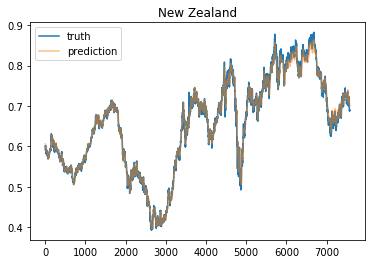

mae:  0.025290882
mape:  0.013769818
smape:  0.013801767
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Singapore
number of parmeters: 7669
epoch:0
training mae loss:0.21150032430887222
testing mae loss:0.6474396586418152
testing mape:0.2214271
epoch:100
training mae loss:0.05763091519474983
testing mae loss:0.07500801980495453
testing mape:0.02541855
epoch:200
training mae loss:0.05042417719960213
testing mae loss:0.07564238458871841
testing mape:0.025569258
epoch:300
training mae loss:0.045011064037680626
testing mae loss:0.07473637163639069
testing mape:0.025241954
epoch:400
training mae loss:0.04069223627448082
testing mae loss:0.07698258012533188
testing mape:0.02598572
epoch:500
training mae loss:0.031029

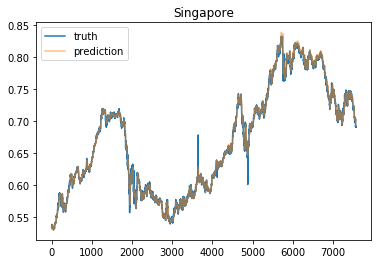

mae:  0.016233852
mape:  0.0056186547
smape:  0.005604995


<Figure size 432x288 with 0 Axes>

In [9]:
import src.two_dim_cnn_gru

method=""

targets=[0,1,2,3,4,5,6]
input_dim=7

hidden_size=32
fc_size=16
input_length=14
output_length=7

cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)

split=2000
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #S2S_2dcnn(cnn_parameters,rnn_hidden_size,fc_size,input_dim,output_length)
    model=src.two_dim_cnn_gru.S2S_2dcnn(cnn_parameters,hidden_size,fc_size,input_dim,output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/2dcnn/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [22]:
model

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
    (W): Linear(in_features=20, out_features=20, bias=False)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 40, batch_first=True)
    (fc1): Linear(in_features=40, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)

# show result

In [40]:
i=5
method='general'
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')

In [41]:
#print(file_name)
data1=data.values
inputs=make_neighbor_list(target=i, input_dim=7)

dataset1, dataset2=make_io(input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

0.024228493
0.01334077


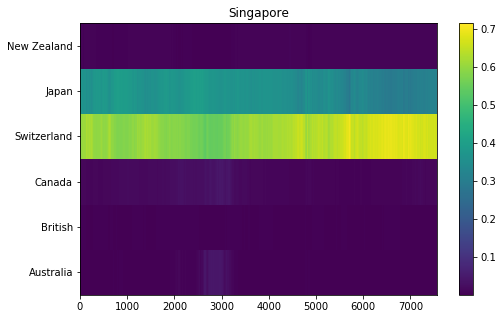

0 0.000273296237208525
1 0.002247381692435997
2 0.00833435965859119
3 0.6725427007181226
4 0.30988332379219685
5 0.006718937397716607


[[0, 0.000273296237208525],
 [1, 0.002247381692435997],
 [5, 0.006718937397716607],
 [2, 0.00833435965859119],
 [4, 0.30988332379219685],
 [3, 0.6725427007181226]]

<Figure size 432x288 with 0 Axes>

In [55]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/'+method+'/')
attns=np.array(attns)
importance=[]
for k in range(1,7):
    print(inputs[k], attns[5587:,k-1].mean())
    importance.append([inputs[k], attns[5587:,k-1].mean()])
importance=sorted(importance, key= lambda importance: importance[1])
importance

# feature importance

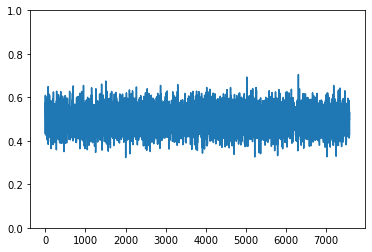

In [9]:
mu=0.5
sigma=0.05
noise=np.random.normal(mu, sigma, len(file))#+0.25*np.sin([0.01*i for i in range(len(file))])
noise=np.expand_dims(noise, axis=1)
plt.ylim(0,1)
plt.plot(noise)

C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.AvgPool1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or

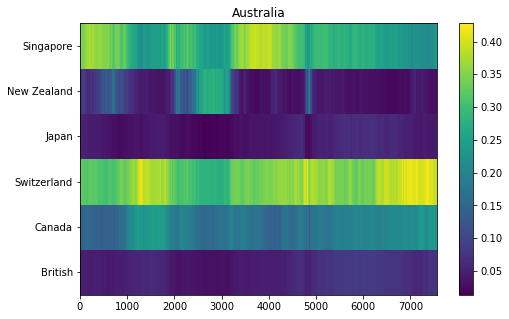

original mae: 0.020477235
original test smape: 0.012382464
original train smape: 0.012974435
1 0.04956373751312841
2 0.17685214714274672
3 0.33670001509941944
4 0.03697651358868401
5 0.0931730356106759
6 0.30673455116903287
0 0
1 0.012530853
2 0.014716009
3 0.012470162
4 0.013368151
5 0.012946129
6 0.016621068


C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'src.model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


<Figure size 432x288 with 0 Axes>

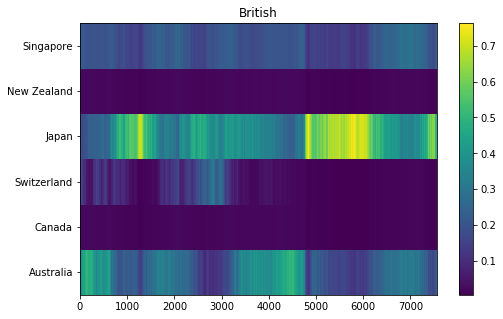

original mae: 0.02209875
original test smape: 0.011086322
original train smape: 0.009033431
0 0.28969390948503243
2 0.017287383330674186
3 0.0763177283836523
4 0.4078783561681109
5 0.01783567973792137
6 0.19098694182309606
0 0.01056545
1 1
2 0.0110863205
3 0.011069536
4 0.01352049
5 0.01108845
6 0.01065436


<Figure size 432x288 with 0 Axes>

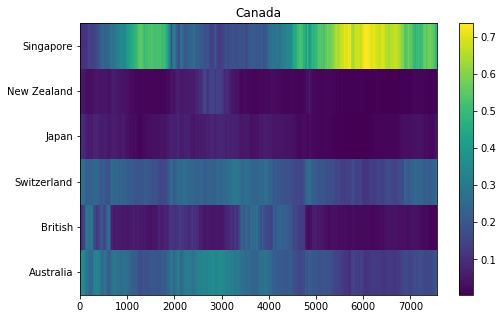

original mae: 0.015305853
original test smape: 0.008237595
original train smape: 0.00729935
0 0.2520594794229166
1 0.11451463199883875
3 0.2201312437949591
4 0.04691321110497565
5 0.04021148585317833
6 0.3261699472959596
0 0.00814115
1 0.007923669
2 2
3 0.007151365
4 0.008244955
5 0.008297084
6 0.009330745


<Figure size 432x288 with 0 Axes>

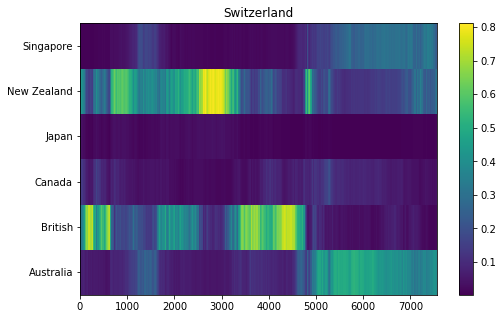

original mae: 0.019457387
original test smape: 0.010096218
original train smape: 0.011227799
0 0.14068039416392034
1 0.35398868974034864
2 0.061265617134611296
4 0.019502056249240167
5 0.36674360666475375
6 0.05781963641760451
0 0.011012639
1 0.0111901425
2 0.010142209
3 3
4 0.010096908
5 0.010434637
6 0.010594903


<Figure size 432x288 with 0 Axes>

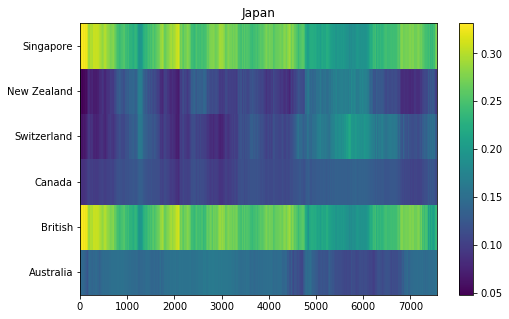

original mae: 0.015452209
original test smape: 0.009792522
original train smape: 0.011588603
0 0.1443906436364745
1 0.257792889791822
2 0.11249307766810115
3 0.11427351986482294
5 0.11276246692584563
6 0.2582874013594743
0 0.009655545
1 0.009685983
2 0.009639728
3 0.009618842
4 4
5 0.010602212
6 0.009792522


<Figure size 432x288 with 0 Axes>

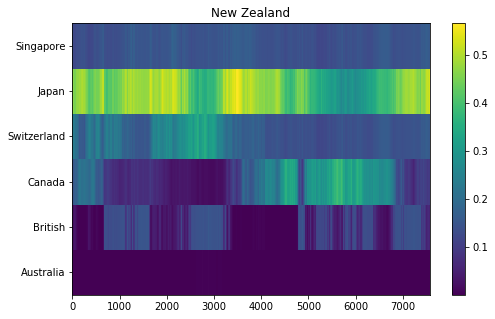

original mae: 0.020877004
original test smape: 0.011432412
original train smape: 0.011231211
0 0.0007538919180943992
1 0.06377761074687108
2 0.14303625463747277
3 0.20113936002083363
4 0.44690861851003616
6 0.1443842648753054
0 0.011435269
1 0.011395779
2 0.011536016
3 0.011434647
4 0.011857103
5 5
6 0.011432412


<Figure size 432x288 with 0 Axes>

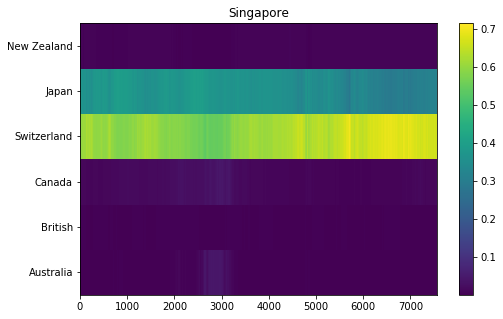

original mae: 0.01620483
original test smape: 0.0055897366
original train smape: 0.004699322
0 0.005305095774812983
1 0.0029710935216328035
2 0.01692130355413117
3 0.602087000924017
4 0.36720583064730655
5 0.00550967534182924
0 0.0056067477
1 0.0055977846
2 0.005683567
3 0.0059754103
4 0.0058752387
5 0.005501058
6 6


<Figure size 432x288 with 0 Axes>

In [10]:
method='bahdanau'
feature_importance=[]
ranks=[]
truths=[]
original_smape=0

for i in range(7):
    file_name=data.columns[i]
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    data1=data.values
    inputs=make_neighbor_list(target=i, input_dim=7)
    dataset1, dataset2=make_io(data1, input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
    attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/'+method+'/')
    print("original mae:",test_mae)
    print("original test smape:",test_smape)
    print("original train smape:", train_smape)
    original_smape+=test_smape
    #original_smape+=train_smape
    
    attns=np.array(attns)
    importance=[]
    for k in range(1,7):
        print(inputs[k], attns[:5587,k-1].mean())
        #print(inputs[k], attns[5587:,k-1].mean())
        importance.append([inputs[k], attns[5587:,k-1].mean()])
        #importance.append([inputs[k], attns[:5587,k-1].mean()])
        
    sorted_importance=sorted(importance, key= lambda importance: importance[1])
    rank=[sorted_importance[i][0] for i in range(6)]
    ranks.append(rank)
    smape=[]
    truth=[]
    #for k in rank:
    for k in range(7):
        if k==i:
            print(i,k)
            smape.append(0)
            continue
            
        data2=data1.copy()
        data2[:,k]=noise.reshape(-1)
        dataset1, dataset2=make_io(data2, input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
        X_train=torch.FloatTensor(dataset1[0])
        Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        #train_smape=util.smape(model(X_train)[:,:,0],Y_train[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        #print(str(k),train_smape)
        #smape.append(train_smape)
        #truth.append([k,train_smape])
        
        print(str(k),test_smape)
        smape.append(test_smape)
        truth.append([k,test_smape])
    
    truth=sorted(truth, key= lambda truth: truth[1])
    feature_importance.append(smape)
    truths.append([sublist[0] for sublist in truth])

In [11]:
FI=pd.DataFrame(feature_importance)#.transpose()
#ranking=pd.DataFrame(ranks)
FI

,0,1,2,3,4,5,6
0,0.000000,0.012531,0.014716,0.012470,0.013368,0.012946,0.016621
1,0.010565,0.000000,0.011086,0.011070,0.013520,0.011088,0.010654
2,0.008141,0.007924,0.000000,0.007151,0.008245,0.008297,0.009331
3,0.011013,0.011190,0.010142,0.000000,0.010097,0.010435,0.010595
4,0.009656,0.009686,0.009640,0.009619,0.000000,0.010602,0.009793
5,0.011435,0.011396,0.011536,0.011435,0.011857,0.000000,0.011432
6,0.005607,0.005598,0.005684,0.005975,0.005875,0.005501,0.000000


In [12]:
col_dict={file.columns[i]:i for i in range(7)}
corr=file[5587:].corr()
#corr=file[:5587].corr()
col_dict

{'Australia': 0,
 'British': 1,
 'Canada': 2,
 'Switzerland': 3,
 'Japan': 4,
 'New Zealand': 5,
 'Singapore': 6}

In [13]:
correlation_ranking=[]
for i in range(7):
    rank=[col_dict[abs(corr[corr.columns[i]]).sort_values().index[j]] for j in range(6)]
    correlation_ranking.append(rank)
correlation_ranking    

[[1, 3, 5, 4, 6, 2],
 [4, 0, 5, 3, 2, 6],
 [3, 1, 4, 5, 6, 0],
 [4, 0, 2, 1, 5, 6],
 [1, 3, 5, 6, 2, 0],
 [4, 1, 3, 0, 2, 6],
 [1, 4, 3, 5, 0, 2]]

In [14]:
model_importance=[]
correlation_importance=[]
truth_importance=[]
for i in range(7):
    model_importance.append([original_smape/7]+[FI.iloc[i][j] for j in ranks[i]])
    correlation_importance.append([original_smape/7]+[FI.iloc[i][j] for j in correlation_ranking[i]])
    truth_importance.append([original_smape/7]+[FI.iloc[i][j] for j in truths[i]])
    

([<matplotlib.axis.XTick at 0x1f143f8b7f0>,
 <a list of 7 Text xticklabel objects>)

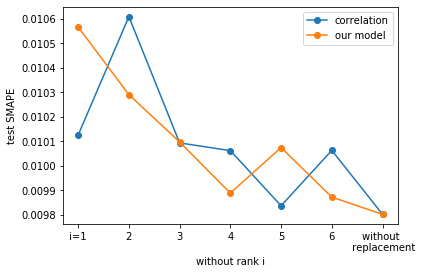

In [15]:
ticks=[str(i) for i in range(1,8)]
ticks[0]="i=1"
ticks[-1]="without \n replacement"

plt.plot(pd.DataFrame(correlation_importance).mean().tolist()[::-1],'-o')
plt.plot(pd.DataFrame(model_importance).mean().tolist()[::-1],'-o')

#plt.ylabel("train SMAPE")
plt.ylabel("test SMAPE")
plt.xlabel("without rank i")
plt.legend(["correlation","our model"])
plt.xticks([i for i in range(7)],ticks)

In [16]:
np.corrcoef(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(7)])

array([[ 1.        , -0.67721279],
       [-0.67721279,  1.        ]])

In [17]:
np.corrcoef(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(7)])

array([[ 1.        , -0.90004194],
       [-0.90004194,  1.        ]])

In [18]:
from scipy import stats
stats.kendalltau(pd.DataFrame(correlation_importance).mean().tolist()[::-1],[i for i in range(7)])

KendalltauResult(correlation=-0.7142857142857143, pvalue=0.03015873015873016)

In [19]:
stats.kendalltau(pd.DataFrame(model_importance).mean().tolist()[::-1],[i for i in range(7)])

KendalltauResult(correlation=-0.9047619047619049, pvalue=0.002777777777777778)


# first/last step performance

In [28]:

def first_last(method, step):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(7):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=7)
        dataset1, dataset2=make_io(input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,step,:],Y_test[:,step,:]))
        smape.append(util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=abs(model(X_test)[:,step,:]-Y_test[:,step,:]).mean()
        #smape+=util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/7, smape/7

In [29]:
first_last(name, 0)

([0.017859615,
  0.014163434,
  0.010226639,
  0.0143228015,
  0.01283046,
  0.014336519,
  0.02256629],
 [0.010726727,
  0.0069221845,
  0.005583575,
  0.00740674,
  0.008233879,
  0.007843382,
  0.007618079])

In [30]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    first=first_last(name, 0)
    #last=first_last(name, -1)
    print(name, "mae:",np.mean(first[0]),"/",np.std(first[0]))
    print(name, "smape:",np.mean(first[1]),"/",np.std(first[1]))

bahdanau mae: 0.015186536 / 0.003669821
bahdanau smape: 0.007762081 / 0.0014450232
dot mae: 0.016124541 / 0.0040148795
dot smape: 0.008498626 / 0.002632806
general mae: 0.016356712 / 0.005310306
general smape: 0.008551119 / 0.002949066
none mae: 0.014503536 / 0.0027744519
none smape: 0.0075691515 / 0.0016186017
lstm mae: 0.025751337 / 0.007485914
lstm smape: 0.013928778 / 0.0047041243
2dcnn mae: 0.018558843 / 0.0075023305
2dcnn smape: 0.010421664 / 0.0054136203


In [31]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    #first=first_last(name, 0)
    last=first_last(name, -1)
    print(name, "mae:",np.mean(last[0]),"/",np.std(last[0]))
    print(name, "smape:",np.mean(last[1]),"/",np.std(last[1]))

bahdanau mae: 0.022944372 / 0.003804596
bahdanau smape: 0.012177437 / 0.0028403858
dot mae: 0.02632149 / 0.0050710337
dot smape: 0.013773365 / 0.0032977525
general mae: 0.024605548 / 0.0039090114
general smape: 0.012988302 / 0.0029519342
none mae: 0.025249736 / 0.0052538207
none smape: 0.013063765 / 0.002615293
lstm mae: 0.03277676 / 0.008465851
lstm smape: 0.017546577 / 0.005454312
2dcnn mae: 0.028305948 / 0.0072280434
2dcnn smape: 0.015459404 / 0.0051957755


In [6]:

def all_performance(method):
    mae=[]
    smape=[]
    for i in range(7):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=7)
        dataset1, dataset2=make_io(input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,:,0],Y_test[:,:,0]))
        smape.append(util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
        #smape+=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/7, smape/7

In [7]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
all_mae=[]
all_smape=[]
for name in model_names:
    mae, smape=all_performance(name)
    all_mae.append(mae)
    all_smape.append(smape)
    #print(name, "mae:",first[0])
    #print(name, "smape:",first[1])

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [8]:
all_mae=pd.DataFrame(all_mae, index=model_names, columns=data.columns).transpose()
all_smape=pd.DataFrame(all_smape,index=model_names, columns=data.columns).transpose()

In [9]:
all_mae

,bahdanau,dot,general,none,lstm,2dcnn
Australia,0.020477,0.020541,0.021039,0.019155,0.032923,0.020292
British,0.022099,0.020510,0.021061,0.023820,0.027845,0.030565
Canada,0.015306,0.016675,0.016206,0.014627,0.029419,0.012762
Switzerland,0.019457,0.027892,0.024277,0.022925,0.039793,0.036069
Japan,0.015452,0.018117,0.016719,0.013671,0.019442,0.031339
New Zealand,0.020877,0.032350,0.024228,0.022253,0.035002,0.025291
Singapore,0.016205,0.018932,0.017333,0.020699,0.016674,0.016234


In [10]:
all_mae.mean(), all_mae.std()

(bahdanau    0.018553
 dot         0.022145
 general     0.020123
 none        0.019593
 lstm        0.028728
 2dcnn       0.024650
 dtype: float64, bahdanau    0.002833
 dot         0.005757
 general     0.003429
 none        0.004025
 lstm        0.008289
 2dcnn       0.008580
 dtype: float64)

In [11]:
all_smape.mean(), all_smape.std()

(bahdanau    0.009802
 dot         0.011625
 general     0.010626
 none        0.010181
 lstm        0.015375
 2dcnn       0.013542
 dtype: float64, bahdanau    0.002282
 dot         0.003602
 general     0.002624
 none        0.002190
 lstm        0.005231
 2dcnn       0.005821
 dtype: float64)

# show all results

In [10]:
method='bahdanau'
os.listdir(path+'/results/models/'+method)

['PT08.S4(NO2).pt',
 'New Zealand_noise.pt',
 'HAS.pt',
 'Japan_noise.pt',
 'PT08.S5(O3).pt',
 'T.pt',
 'Switzerland.pt',
 'GOOG.pt',
 'British.pt',
 'Global_reactive_power.pt',
 'PT08.S2(NMHC).pt',
 'Japan.pt',
 'British_noise.pt',
 'CTAS.pt',
 'Australia_noise1.pt',
 'RH.pt',
 'PT08.S1(CO).pt',
 'AH.pt',
 'Switzerland_noise.pt',
 'PT08.S3(NOx).pt',
 'Canada_noise.pt',
 'Canada.pt',
 'Voltage.pt',
 'New Zealand.pt',
 'Global_intensity.pt',
 'Australia.pt',
 'Singapore_noise.pt',
 'C6H6(GT).pt',
 'Global_active_power.pt',
 'Singapore.pt',
 'Australia_noise.pt']

In [12]:
method='bahdanau'
attns=[]
for i in range(7):
    file_name=data.columns[i]
    print(file_name)
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    inputs=make_neighbor_list(target=i, input_dim=7)

    dataset1, dataset2=make_io(input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    
    weights=[]
    for j in range(len(X_train)):
        _,_,sample=model.encoder(X_train[i].unsqueeze(0))
        weights.append(sample[0][0].tolist())
    
    for j in range(len(X_test)):
        _,_,sample=model.encoder(X_test[i].unsqueeze(0))
        weights.append(sample[0][0].tolist())  
        
    attns.append(weights)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print(test_mae)
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print(test_mape)
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print(test_smape)

Australia
0.020477235
0.012411901
0.0123824645
British
0.02209875
0.011185773
0.011086322
Canada
0.015305853
0.008281968
0.008237595
Switzerland
0.019457389
0.010056444
0.010096218
Japan
0.015452209
0.009804485
0.009792522
New Zealand
0.020877002
0.011428688
0.01143241
Singapore
0.01620483
0.0055811317
0.005589736


In [16]:
data.columns

Index(['Australia', 'British', 'Canada', 'Switzerland', 'Japan', 'New Zealand',
       'Singapore'],
      dtype='object')